# Kristalball - Astitva Agarwal

## Problem Statement: Intelligent Forecasting and Inventory Planning for Bar Operations

The hospitality group operates a chain of bars across multiple locations, each catering to a unique customer base with varying preferences and consumption patterns. Managing inventory across this decentralized setup is both crucial and challenging. 

Currently, inventory planning for alcohol brands at each bar is largely manual or based on rough estimations. This has led to two persistent operational issues:

1. **Stockouts** — When a popular brand is not available at a bar, it leads to disappointed customers, missed sales opportunities, and a loss of brand reputation.
2. **Overstocking** — Keeping excessive inventory "just in case" ties up working capital, increases holding costs, and sometimes results in spoilage or product expiry, especially for slower-moving brands.

### Objective
The objective of this project is to **build a data-driven forecasting and inventory recommendation system** that uses historical consumption data to guide smarter inventory decisions. Specifically, the system aims to:
- Analyze historical alcohol consumption trends across different bars and brands.
- Forecast the expected demand for each brand at each bar over a future time window (e.g., 30 days).
- Recommend optimal 'par levels', i.e., the minimum amount of stock each bar should maintain for each brand to avoid stockouts while minimizing overstock risk.





#### Importing necessary libraries

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Reading the Dataset

In [36]:
excel_file = pd.ExcelFile('Consumption Dataset.xlsx')
df = pd.read_excel(excel_file, sheet_name='Dataset')
df.head()
df.tail()


,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
6570,2024-01-01 21:03:00,Anderson's Bar,Beer,Coors,2.467080e+03,0.00,321.06,2146.02
6571,2024-01-01 21:15:00,Anderson's Bar,Rum,Malibu,8.526513e-14,1743.64,175.05,1568.59
6572,2024-01-01 18:34:00,Anderson's Bar,Whiskey,Jack Daniels,4.192660e+03,0.00,197.60,3995.06
6573,2024-01-01 22:46:00,Thomas's Bar,Vodka,Absolut,2.424950e+03,0.00,128.52,2296.43
6574,2024-01-01 21:26:00,Thomas's Bar,Rum,Bacardi,1.778360e+03,1195.45,572.60,2401.21


#### Exploratory Data Analysis on Consumption

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date Time Served      6575 non-null   datetime64[ns]
 1   Bar Name              6575 non-null   object        
 2   Alcohol Type          6575 non-null   object        
 3   Brand Name            6575 non-null   object        
 4   Opening Balance (ml)  6575 non-null   float64       
 5   Purchase (ml)         6575 non-null   float64       
 6   Consumed (ml)         6575 non-null   float64       
 7   Closing Balance (ml)  6575 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 411.1+ KB
None
Missing values:
 Date Time Served        0
Bar Name                0
Alcohol Type            0
Brand Name              0
Opening Balance (ml)    0
Purchase (ml)           0
Consumed (ml)           0
Closing Balance (ml)    0
dtype: int6

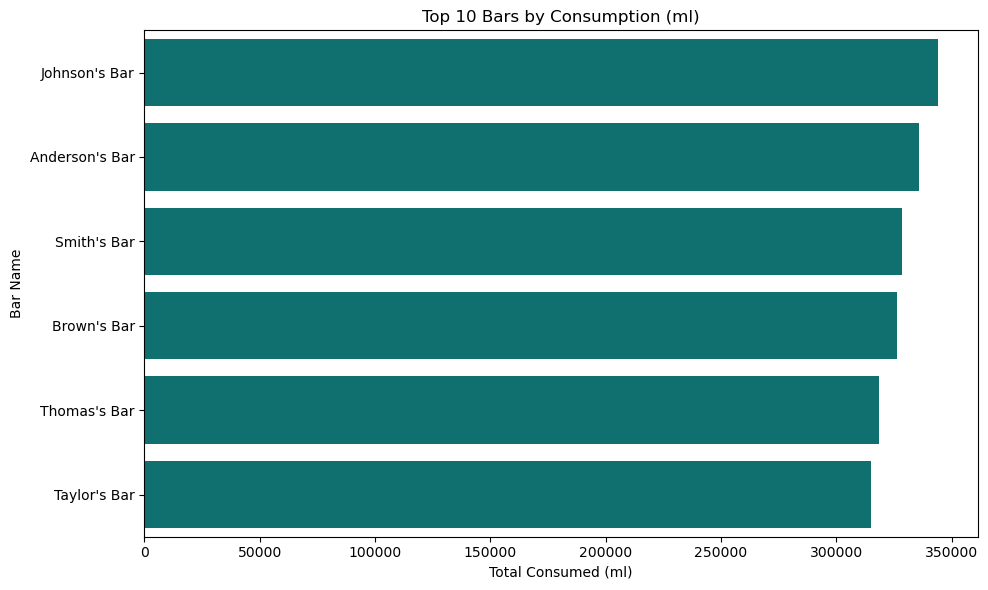

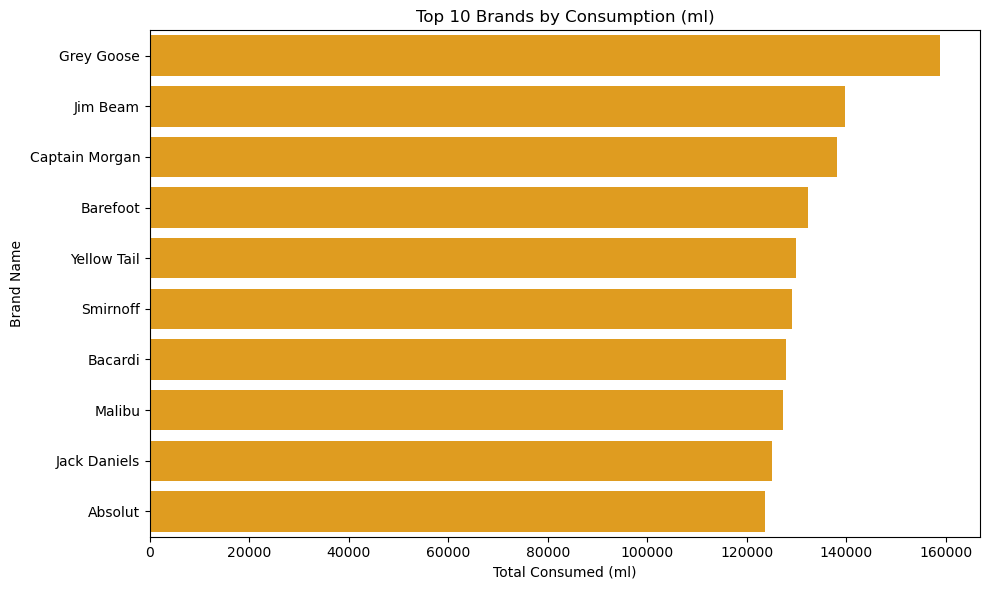

Consumption by Alcohol Type:
 Alcohol Type
Vodka      411759.71
Beer       399498.39
Rum        393266.84
Whiskey    384754.46
Wine       379402.26
Name: Consumed (ml), dtype: float64


C:\Users\agarw\AppData\Local\Temp\ipykernel_14768\2259406025.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_alcohol.values, y=top_alcohol.index, palette=colors)


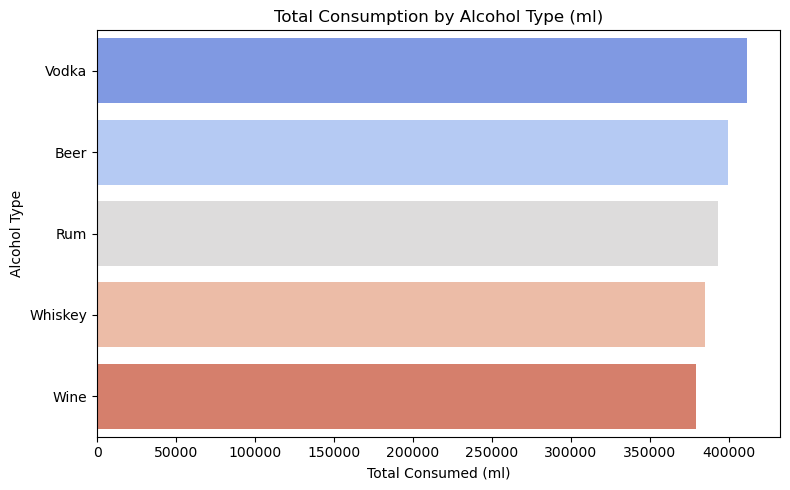

In [37]:
%matplotlib inline

print(df.info())
print("Missing values:\n", df.isnull().sum())
df['Consumed (ml)'] = pd.to_numeric(df['Consumed (ml)'], errors='coerce') #Converting the values to integer or NaN values 

top_bars = df.groupby('Bar Name')['Consumed (ml)'].sum().sort_values(ascending=False).head(10) # Top 10 bars by consumption
# print("Top 10 Bars:", top_bars)          

top_brands = df.groupby('Brand Name')['Consumed (ml)'].sum().sort_values(ascending=False).head(10) # Top 10 brands by consumption
# print("Top 10 Brands:", top_brands)

# Plot top 10 bars 
plt.figure(figsize=(10, 6))
sns.barplot(x=top_bars.values, y=top_bars.index, color='teal')
plt.title("Top 10 Bars by Consumption (ml)")
plt.xlabel("Total Consumed (ml)")
plt.ylabel("Bar Name")
plt.tight_layout()
plt.show()

# Plotting top 10 brands
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.values, y=top_brands.index, color='orange')
plt.title("Top 10 Brands by Consumption (ml)")
plt.xlabel("Total Consumed (ml)")
plt.ylabel("Brand Name")
plt.tight_layout()
plt.show()

# consumption by Alcohol Type
top_alcohol = df.groupby('Alcohol Type')['Consumed (ml)'].sum().sort_values(ascending=False)
print("Consumption by Alcohol Type:\n", top_alcohol)

# Plotting consumption by Alcohol Type 
colors = sns.color_palette("coolwarm", n_colors=len(top_alcohol))
plt.figure(figsize=(8, 5))
sns.barplot(x=top_alcohol.values, y=top_alcohol.index, palette=colors)
plt.title("Total Consumption by Alcohol Type (ml)")
plt.xlabel("Total Consumed (ml)")
plt.ylabel("Alcohol Type")
plt.tight_layout()
plt.show()

#### Data Overview and Consumption Analysis



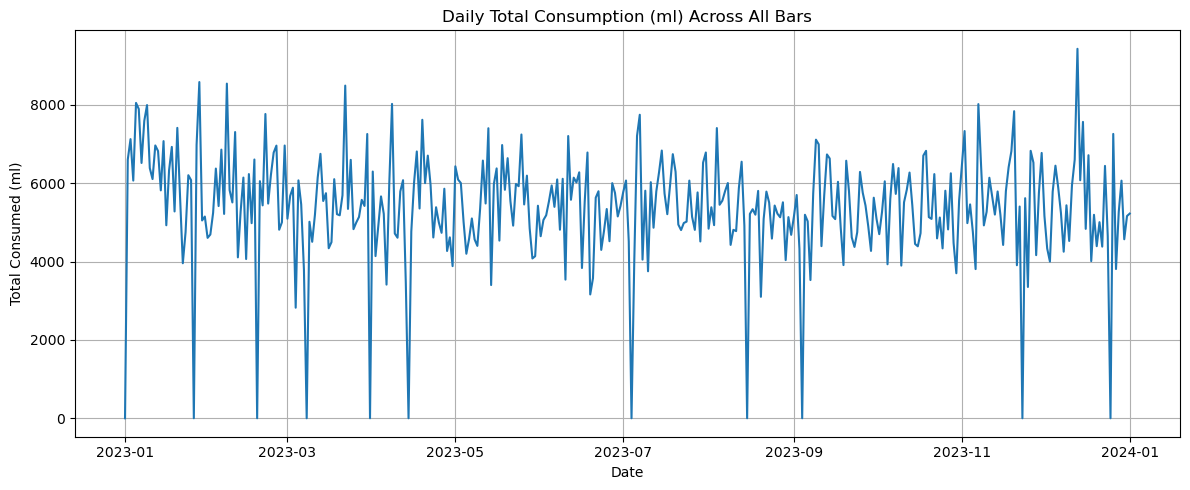

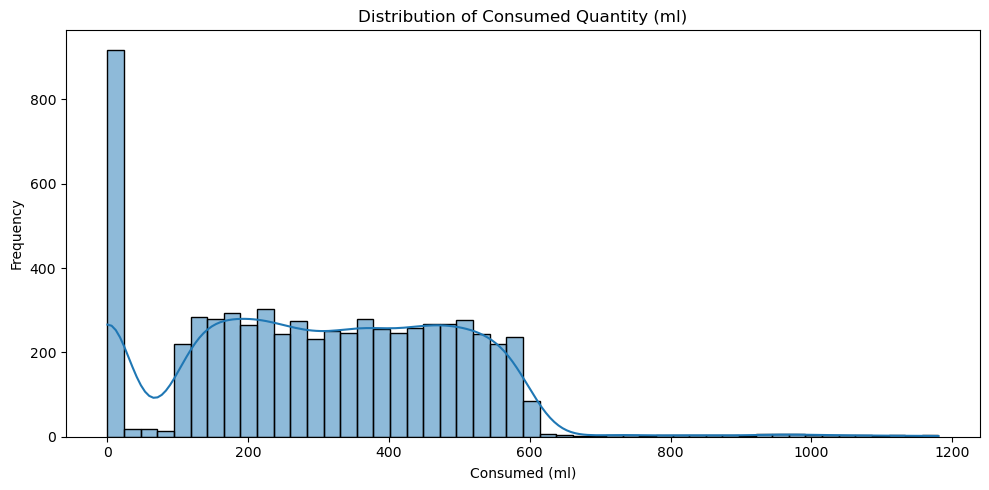

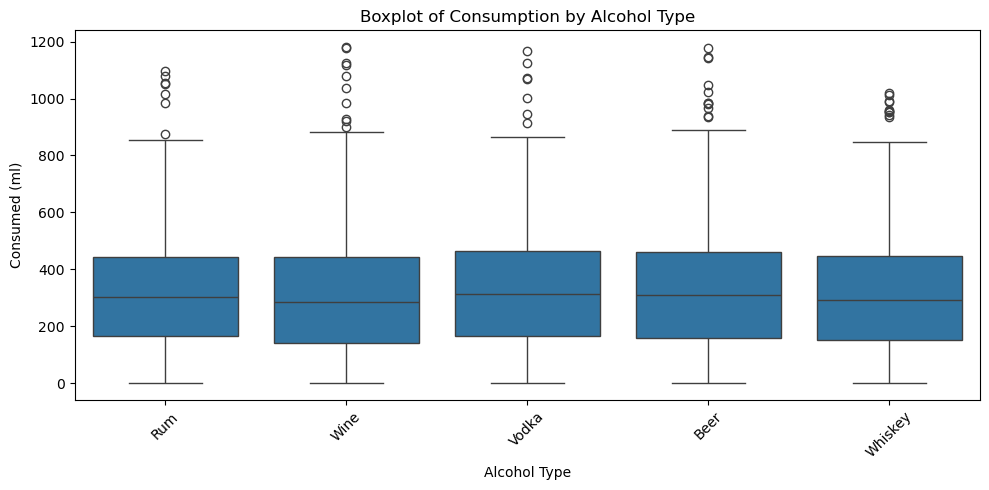

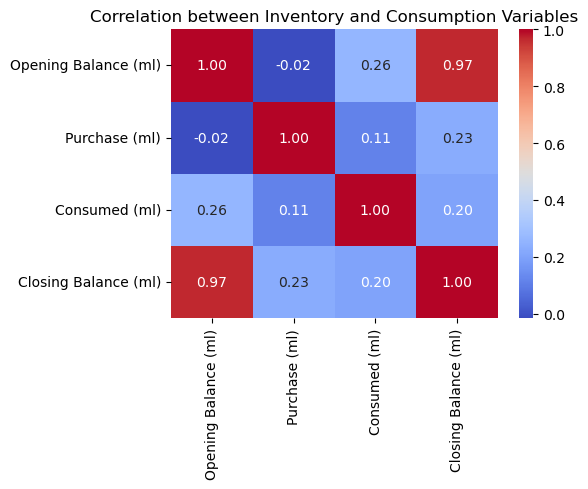

C:\Users\agarw\AppData\Local\Temp\ipykernel_14768\986798262.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_consumption.index, y=dow_consumption.values, palette='Spectral')


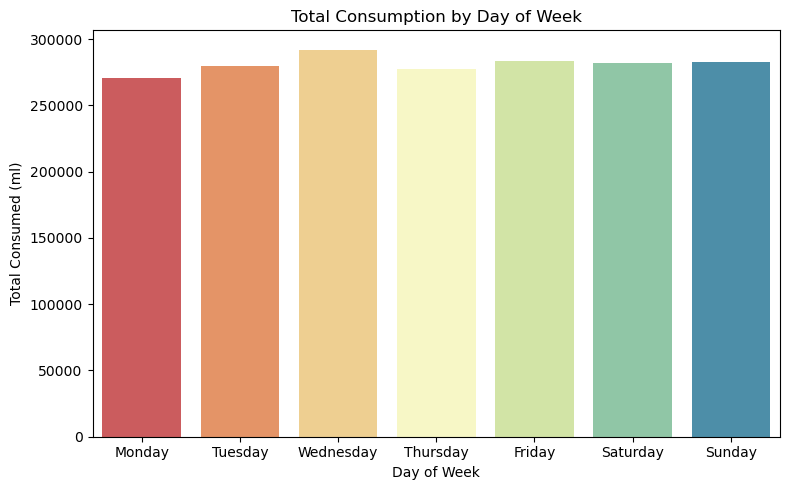

Number of low stock occurrences (Closing Balance < 10% avg opening balance): 1232
Number of high stock occurrences (Closing Balance > 150% avg opening balance): 1755


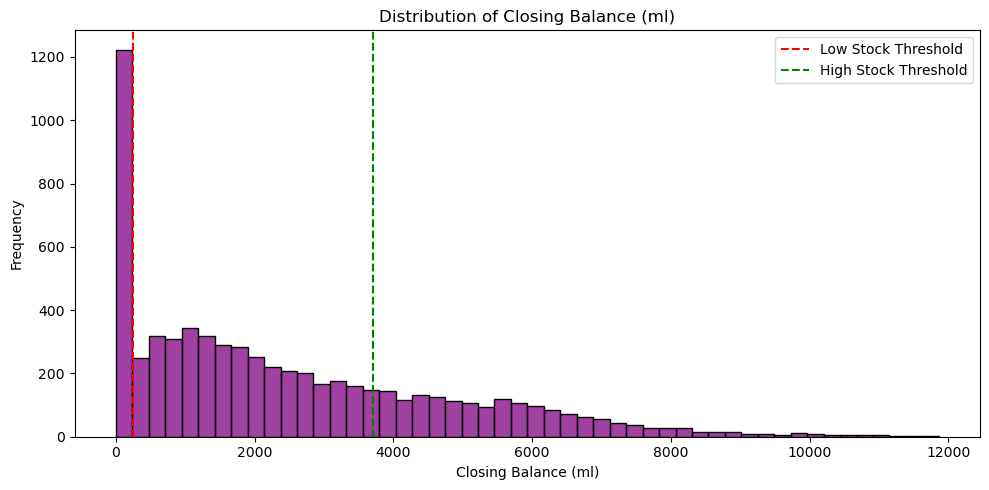

In [38]:

df['Date Time Served'] = pd.to_datetime(df['Date Time Served'], errors='coerce') #Converting the Column to Datetime format

# total consumption across all bars
daily_consumption = df.groupby(df['Date Time Served'].dt.date)['Consumed (ml)'].sum()
plt.figure(figsize=(12,5))
daily_consumption.plot()
plt.title('Daily Total Consumption (ml) Across All Bars')
plt.xlabel('Date')
plt.ylabel('Total Consumed (ml)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of Consumption
plt.figure(figsize=(10,5))
sns.histplot(df['Consumed (ml)'].dropna(), bins=50, kde=True)
plt.title('Distribution of Consumed Quantity (ml)')
plt.xlabel('Consumed (ml)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Alcohol Type', y='Consumed (ml)', data=df)
plt.title('Boxplot of Consumption by Alcohol Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap
corr_cols = ['Opening Balance (ml)', 'Purchase (ml)', 'Consumed (ml)', 'Closing Balance (ml)']
corr_data = df[corr_cols].apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(6,5))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Inventory and Consumption Variables')
plt.tight_layout()
plt.show()

# --- 4. Seasonality: Consumption by Day of Week ---
df['Day of Week'] = df['Date Time Served'].dt.day_name()
dow_consumption = df.groupby('Day of Week')['Consumed (ml)'].sum()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_consumption = dow_consumption.reindex(dow_order)

plt.figure(figsize=(8,5))
sns.barplot(x=dow_consumption.index, y=dow_consumption.values, palette='Spectral')
plt.title('Total Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Consumed (ml)')
plt.tight_layout()
plt.show()

# --- 5. Inventory Dynamics: Frequency of Low and High Stock (Closing Balance) ---

# Define thresholds for low stock (e.g., less than 10% of average opening balance) and high stock (e.g., >150%)
threshold_low = 0.1 * df['Opening Balance (ml)'].mean()
threshold_high = 1.5 * df['Opening Balance (ml)'].mean()

low_stock_freq = (df['Closing Balance (ml)'] < threshold_low).sum()
high_stock_freq = (df['Closing Balance (ml)'] > threshold_high).sum()

print(f"Number of low stock occurrences (Closing Balance < 10% avg opening balance): {low_stock_freq}")
print(f"Number of high stock occurrences (Closing Balance > 150% avg opening balance): {high_stock_freq}")

# Histogram of Closing Balances to visualize stock distribution
plt.figure(figsize=(10,5))
sns.histplot(df['Closing Balance (ml)'].dropna(), bins=50, color='purple')
plt.axvline(threshold_low, color='red', linestyle='--', label='Low Stock Threshold')
plt.axvline(threshold_high, color='green', linestyle='--', label='High Stock Threshold')
plt.title('Distribution of Closing Balance (ml)')
plt.xlabel('Closing Balance (ml)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
!pip install prophet

  Using cached prophet-1.1.6-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached holidays-0.73-py3-none-any.whl.metadata (38 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.6-py3-none-win_amd64.whl (13.3 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Using cached holidays-0.73-py3-none-any.whl (954 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)


Loading the Excel file and converting it to the requirements 


In [40]:
excel_file = pd.ExcelFile('Consumption Dataset.xlsx')
df = pd.read_excel(excel_file, sheet_name='Dataset')

df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])
df['Consumed (ml)'] = pd.to_numeric(df['Consumed (ml)'], errors='coerce')

df.dropna(subset=['Consumed (ml)', 'Date Time Served'], inplace=True)
print("Data sample:")
print(df.head())

print("\nData info:")
print(df.info())

Data sample:
     Date Time Served       Bar Name Alcohol Type      Brand Name  \
0 2023-01-01 19:35:00    Smith's Bar          Rum  Captain Morgan   
1 2023-01-01 10:07:00    Smith's Bar         Wine     Yellow Tail   
2 2023-01-01 11:26:00  Johnson's Bar        Vodka      Grey Goose   
3 2023-01-01 13:53:00  Johnson's Bar         Beer           Coors   
4 2023-01-01 22:28:00  Johnson's Bar         Wine     Yellow Tail   

   Opening Balance (ml)  Purchase (ml)  Consumed (ml)  Closing Balance (ml)  
0               2555.04        1824.84            0.0               4379.88  
1               1344.37           0.00            0.0               1344.37  
2               1034.28           0.00            0.0               1034.28  
3               2194.53           0.00            0.0               2194.53  
4               1020.90           0.00            0.0               1020.90  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (tota

#### Changing the Dataset according to Prophet 


In [41]:
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])
df_agg = df.groupby([
    df['Date Time Served'].dt.date,  
    'Bar Name',
    'Brand Name'
])['Consumed (ml)'].sum().reset_index()
print(df_agg.head())

# Renaming the date column to 'ds' and consumption to 'y' for Prophet
df_agg.rename(columns={
    'Date Time Served': 'ds',
    'Consumed (ml)': 'y'
}, inplace=True)

df_agg['ds'] = pd.to_datetime(df_agg['ds']) #Ensuring 'ds' is in datetime format
print(df_agg.head())

  Date Time Served        Bar Name      Brand Name  Consumed (ml)
0       2023-01-01  Anderson's Bar         Bacardi            0.0
1       2023-01-01  Anderson's Bar        Jim Beam            0.0
2       2023-01-01  Anderson's Bar          Miller            0.0
3       2023-01-01  Anderson's Bar     Sutter Home            0.0
4       2023-01-01     Brown's Bar  Captain Morgan            0.0
          ds        Bar Name      Brand Name    y
0 2023-01-01  Anderson's Bar         Bacardi  0.0
1 2023-01-01  Anderson's Bar        Jim Beam  0.0
2 2023-01-01  Anderson's Bar          Miller  0.0
3 2023-01-01  Anderson's Bar     Sutter Home  0.0
4 2023-01-01     Brown's Bar  Captain Morgan  0.0


## Plotting the graph of Daily consumption of all brands of all bars 


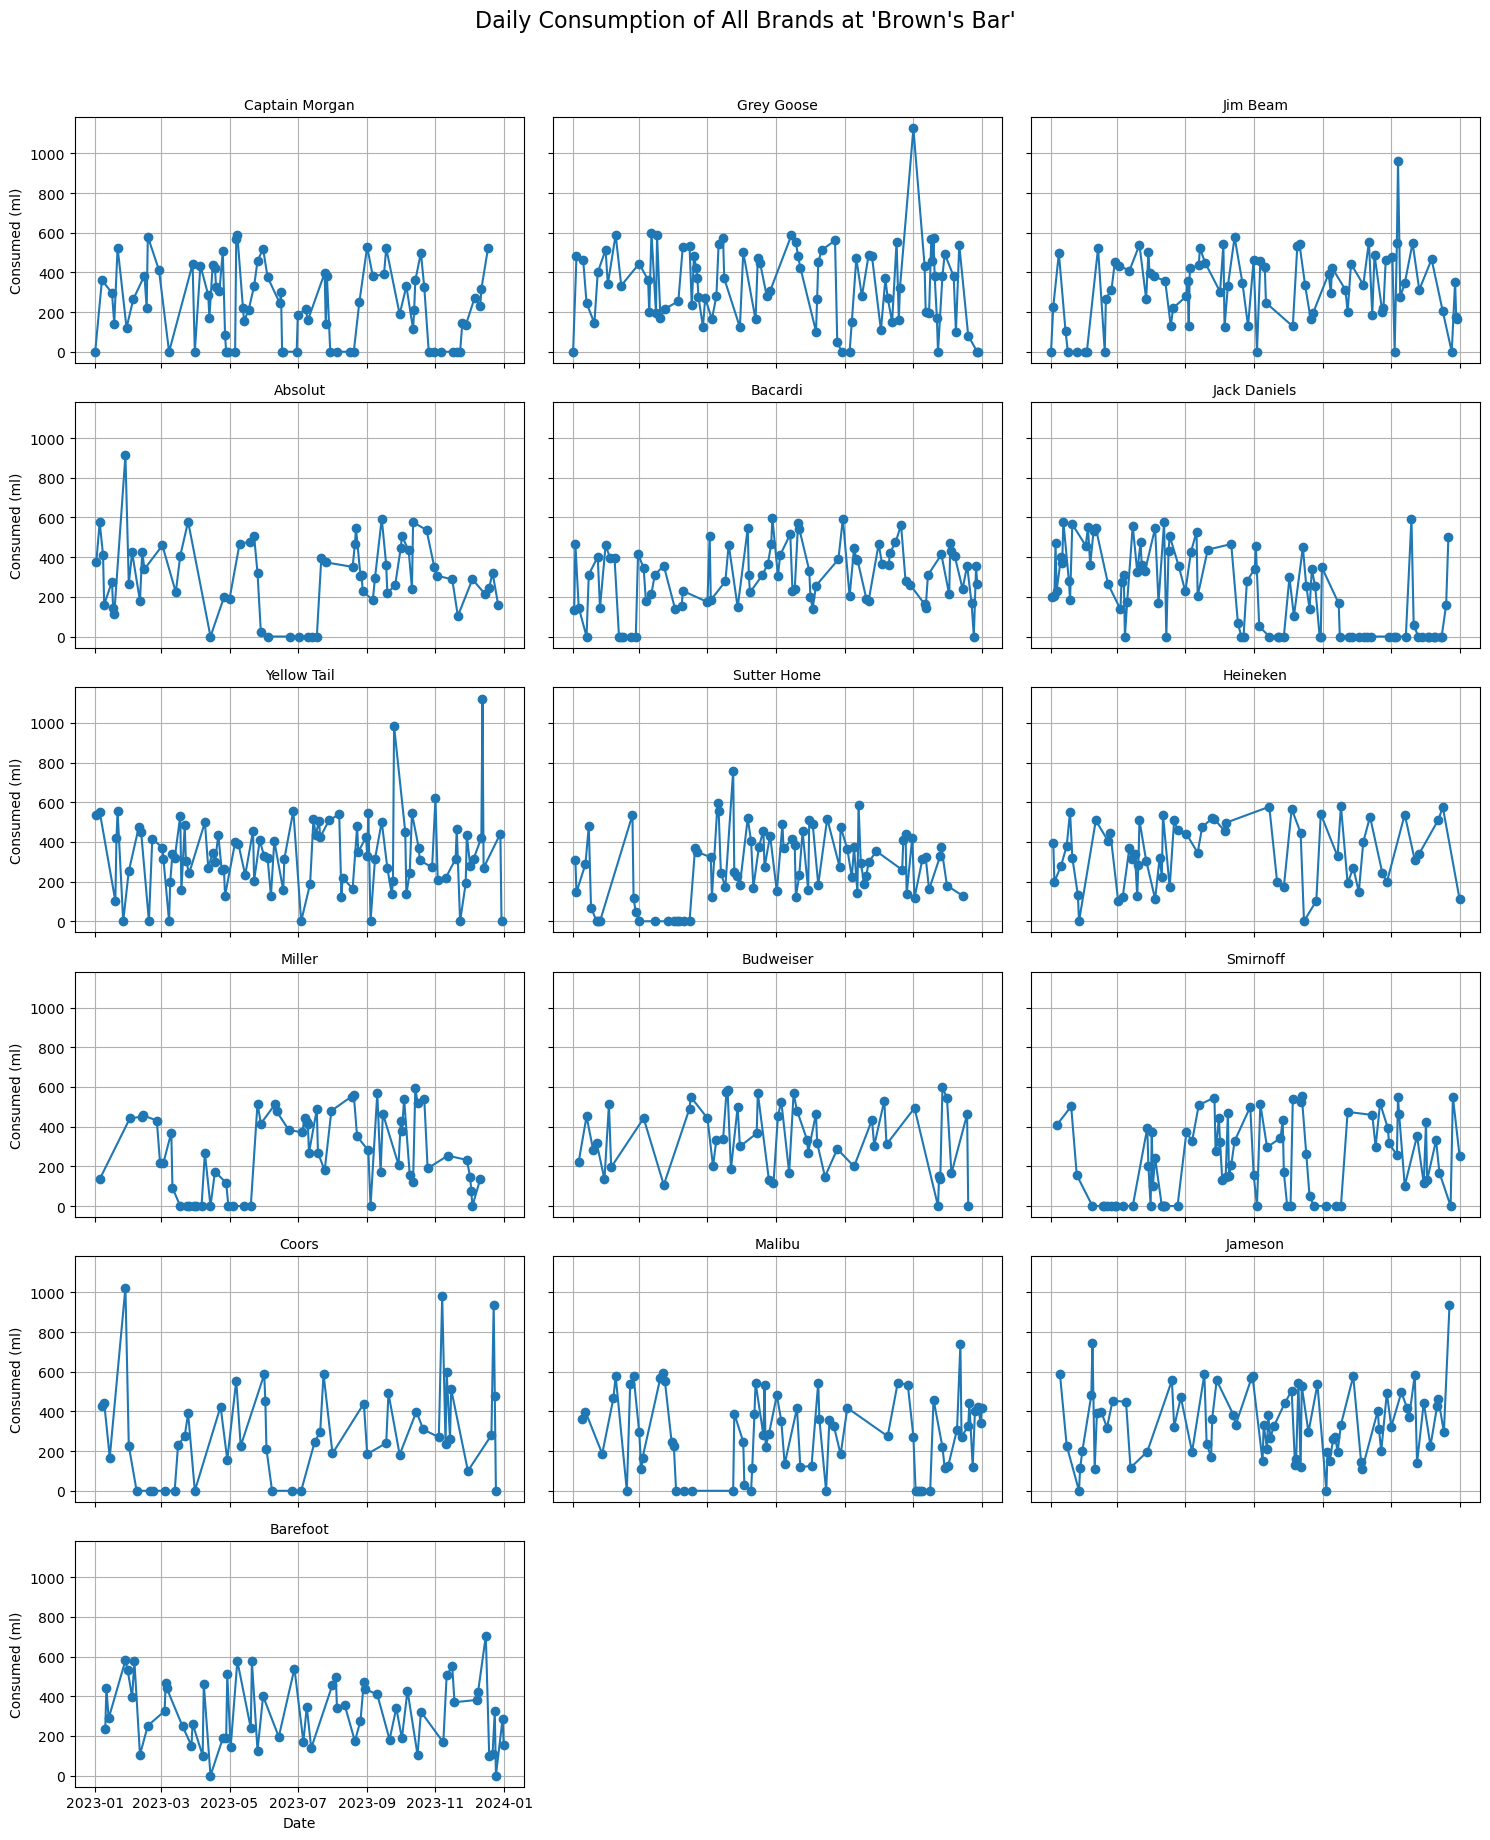

In [42]:
import math

brands = df_bar['Brand Name'].unique()
n_brands = len(brands)


n_cols = 3
n_rows = math.ceil(n_brands / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True, sharey=True)
fig.suptitle(f"Daily Consumption of All Brands at '{bar_name}'", fontsize=16, y=1.02)


axes = axes.flatten()

# Plot each brand in its own subplot
for i, brand in enumerate(brands):
    df_brand = df_bar[df_bar['Brand Name'] == brand]
    axes[i].plot(df_brand['ds'], df_brand['y'], marker='o', label=brand)
    axes[i].set_title(brand, fontsize=10)
    axes[i].grid(True)
    
    if i // n_cols == n_rows - 1:
        axes[i].set_xlabel("Date")
    
    if i % n_cols == 0:
        axes[i].set_ylabel("Consumed (ml)")


for i in range(n_brands, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



Selected pair for forecasting: Bar = 'Thomas's Bar', Brand = 'Yellow Tail'


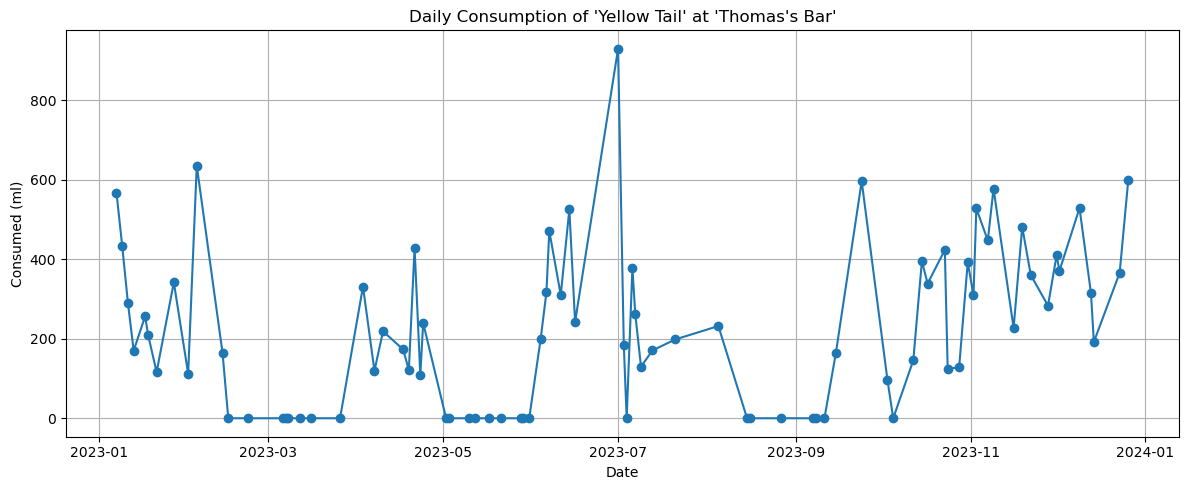

In [43]:
top_combos = df_agg.groupby(['Bar Name', 'Brand Name'])['y'].sum().sort_values(ascending=False).head(10)
# print("\nTop 10 Bar-Brand Pairs:\n", top_combos)

# Choosing only one pair to forecast
bar_name = top_combos.index[1][0]
brand_name = top_combos.index[0][1]

print(f"\nSelected pair for forecasting: Bar = '{bar_name}', Brand = '{brand_name}'")

# Filter data for that specific pair
df_pair = df_agg[(df_agg['Bar Name'] == bar_name) & (df_agg['Brand Name'] == brand_name)][['ds', 'y']].sort_values('ds')

# Plotting time series
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df_pair['ds'], df_pair['y'], marker='o')
plt.title(f"Daily Consumption of '{brand_name}' at '{bar_name}'")
plt.xlabel("Date")
plt.ylabel("Consumed (ml)")
plt.grid(True)
plt.tight_layout()
plt.show()

16:57:35 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing


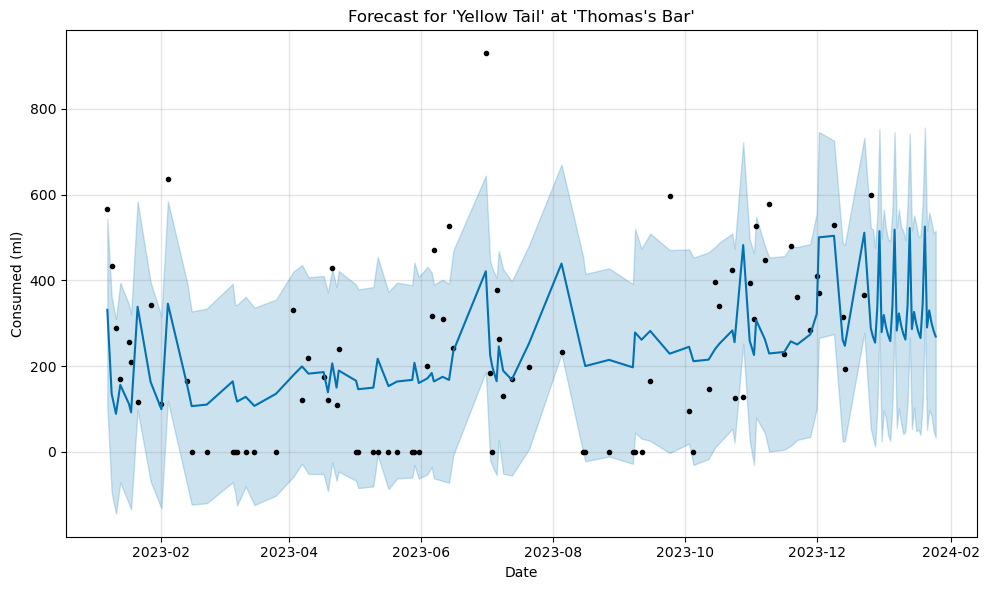

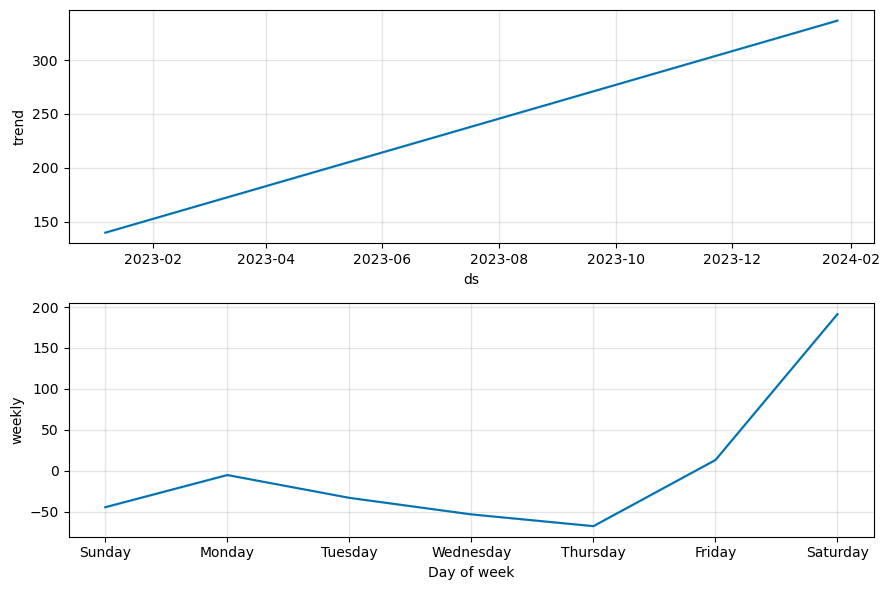

In [44]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Fit the model on the data
model.fit(df_pair)

# Create a DataFrame to hold future dates (e.g., next 30 days)
future = model.make_future_dataframe(periods=30)

# Forecast
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title(f"Forecast for '{brand_name}' at '{bar_name}'")
plt.xlabel("Date")
plt.ylabel("Consumed (ml)")
plt.tight_layout()
plt.show()

# Plot components (trend, weekly, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge actuals with forecast
merged = pd.merge(df_pair, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate evaluation metrics
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 149.77
RMSE: 180.17


# Report

# Project Summary and Key Takeaways

In this project, we set out to understand and forecast alcohol consumption patterns across multiple bars and brands to help optimize inventory and reduce wastage. By analyzing consumption data, we aimed to identify trends and make informed recommendations on inventory par levels.

### Why We Chose This Model

We selected the Prophet forecasting model for several reasons:

- **Robustness with Time Series Data:** Prophet is designed to handle noisy, irregular time series data well, which fits our dataset that includes varying daily consumption volumes.
- **Seasonality Handling:** It naturally models seasonal effects, trends, and holidays, which can be crucial in predicting bar consumption influenced by weekends, holidays, and events.
- **Ease of Use:** Prophet allows quick experimentation and interpretation with minimal hyperparameter tuning, making it practical for this business use case.

### Assumptions Made

- **Stationarity Within Aggregated Periods:** We aggregated consumption by day, assuming daily totals capture sufficient patterns, and that intra-day variations are less critical for forecasting demand.
- **Consistency in Data Quality:** We assumed the recorded consumption data is accurate and representative, ignoring potential missing or erroneous entries after basic cleaning.
- **Homogeneity of Bars:** For the scope of the model, we treated each bar independently, assuming consumption patterns are localized and don’t significantly impact each other.

### Why Focus on One Bar and One Brand for Testing?

Testing on one bar and one brand allowed us to:

- **Simplify Model Validation:** Focusing on a single combination reduces complexity and helps verify the model’s performance before scaling.
- **Highlight Specific Demand Patterns:** It’s easier to analyze and interpret the forecast accuracy and inventory recommendations when dealing with a controlled subset.
- **Resource Efficiency:** Training multiple models or forecasting every bar-brand combination would require significant computational resources and time, which might not be feasible initially.

### Final Thoughts

The results showed reasonable forecast accuracy with MAE and RMSE values indicating the model captures general consumption trends well. These insights can guide inventory decisions, minimizing stockouts and overstocking. For future work, scaling the approach to cover multiple bars and brands, incorporating external factors like promotions or events, and refining model tuning can further improve recommendations.
